# Gender Classification & Age Estimation using Multi-Task CNNs

<a target="_blank" href="https://colab.research.google.com/github/Mhmd-Hisham/GenderDetectionCNN/blob/main/Multi_Task_CNNs_for_Gender_Classification_and_Age_Estimation.ipynb">
<img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab

<a href="https://github.com/Mhmd-Hisham/GenderDetectionCNN/blob/main/Multi_Task_CNNs_for_Gender_Classification_and_Age_Estimation.ipynb">
    <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
    View on GitHub
</a>


**Dataset**

UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization, etc.

Dataset source: https://www.kaggle.com/datasets/jangedoo/utkface-new

**Performance Metrics**

The metrics used for measuring the performance on the test set are:
- gender classification: accuracy
- age estimation: MAE (Mean Absolute Error)

# Environment Setup

In [2]:
import random
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense, Input
from keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

SEED = 1234
TEST_SIZE = 0.2
SHIFT_RANGE = 30
AUGMENTATION_PERCENTAGE = 1/3

random.seed(SEED)
np.random.seed(SEED)

plt.style.use('ggplot')
sns.set_theme(style="dark")
PATH_TO_TRAIN_VAL = "train_val"
os.chdir(PATH_TO_TRAIN_VAL)

# Loading the Dataset

In [3]:
# list all files in the directory and shuffle them
files = np.array(sorted(os.listdir()))
random.shuffle(files)

# loads an image and its labels
load_img = lambda filename: (np.array(PIL.Image.open(filename)), filename.split("_")[:2])
X = list(map(load_img, files))
Y = np.array([x[1] for x in X]).astype(np.float32)
X = np.array([x[0] for x in X]).astype(np.float32)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)

X.shape: (5000, 128, 128, 3)
Y.shape: (5000, 2)


# Inspecting the Dataset

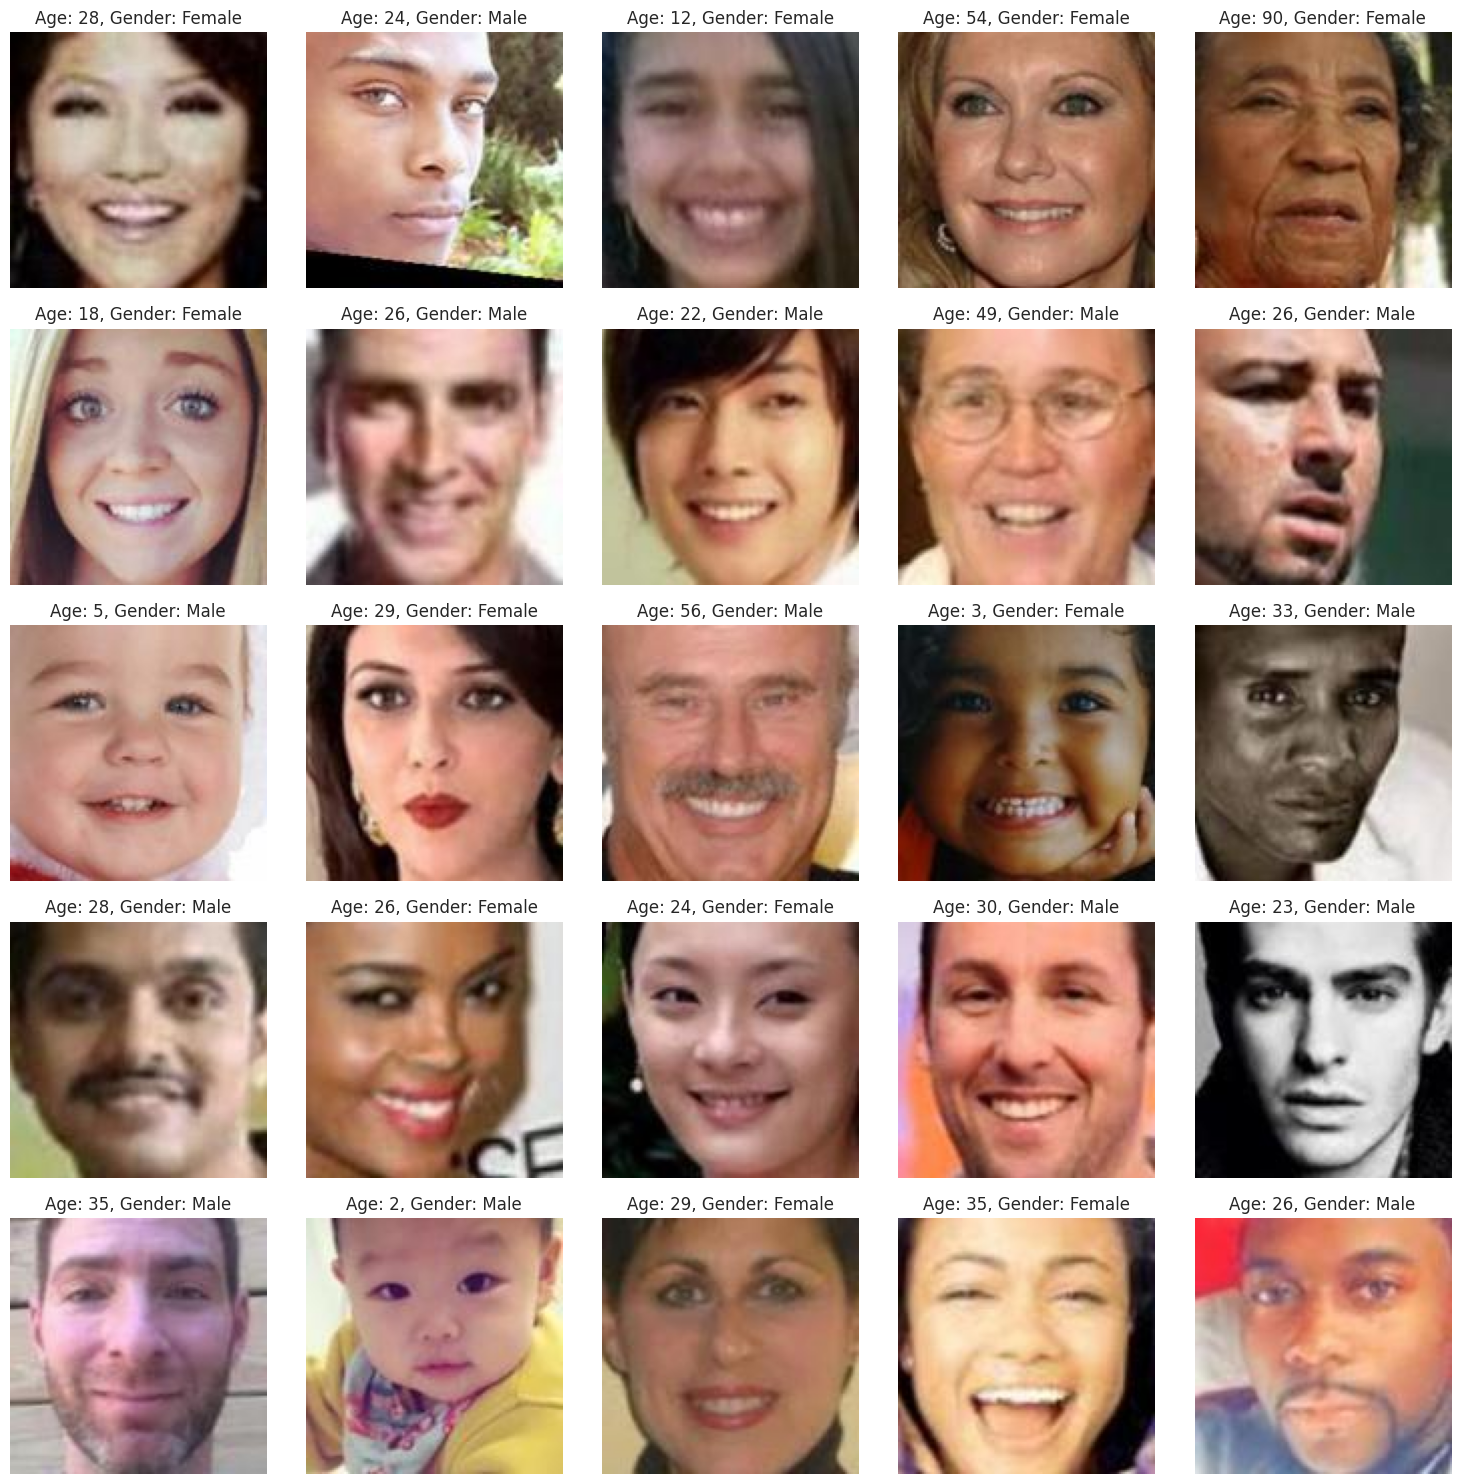

In [4]:
gender_to_label = lambda code: "Male" if int(code) == 0 else "Female"

# create a 5x5 grid of images
fig, axis = plt.subplots(5, 5, figsize=(15, 15))
axis = axis.flatten()
for ax, filename in zip(axis, files[:25]):
    img, (age, gender) = load_img(filename)
    gender = gender_to_label(gender)

    ax.imshow(img)
    ax.axis(False)
    ax.set_title(f"Age: {age}, Gender: {gender}")

plt.tight_layout()
plt.show()

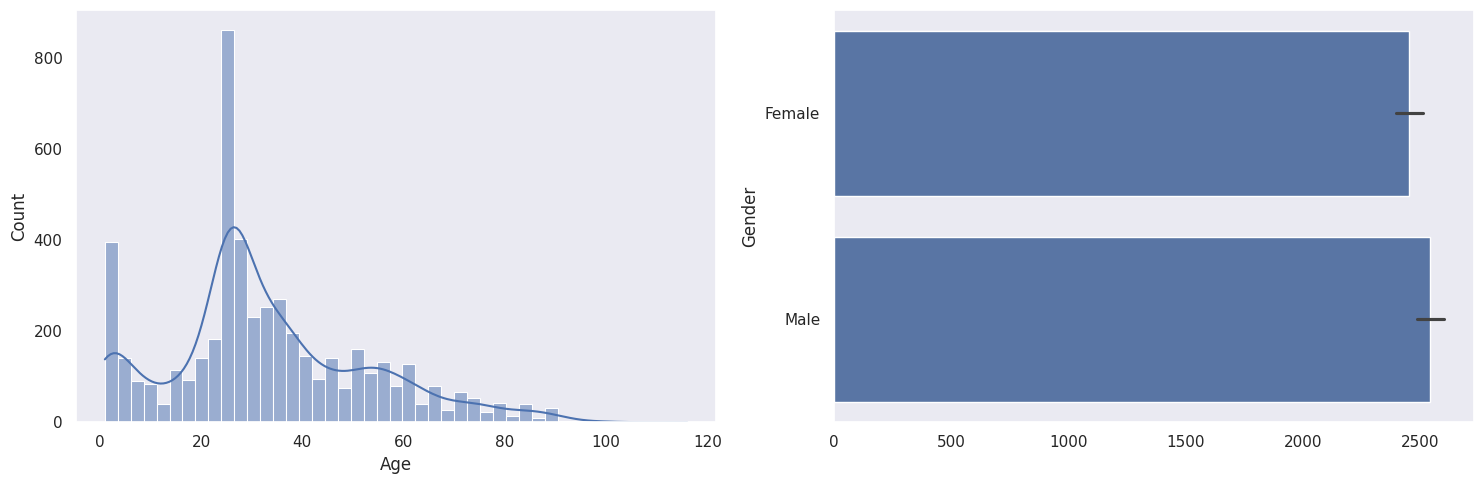

In [5]:
# plot dataset distributions
df = pd.DataFrame(data=Y, columns=["Age", "Gender"])
fig, axis = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df.Age, kde=True, ax=axis[0])
sns.barplot(df.Gender.apply(gender_to_label), ax=axis[1],)
plt.tight_layout()
plt.show()

## Data Preprocessing

1.	Rescale the pixel values to [0,1].
2.	Data augmentation.

In [6]:
# copy the data
X_aug, Y_aug = X.copy(), Y.copy()

# augmentation helper functions
horizontal_flip = lambda img: img[:,:,::-1,:]
get_random_value = lambda: np.random.choice(np.arange(-SHIFT_RANGE, SHIFT_RANGE))

def shift_image(X):
    dx, dy = get_random_value(), get_random_value()
    # dy = np.random.choice(np.arange(min_shift, max_shift))
    X = np.roll(np.roll(X, dy, axis=1), dx, axis=2)

    # fill empty pixels with zeros
    if dy>0: X[:, :dy, :] = 0
    elif dy<0: X[:, dy:, :] = 0

    if dx>0: X[:, :, :dx] = 0
    elif dx<0: X[:, :, dx:] = 0

    return X

def rotate_image(X):
    return np.array([PIL.Image.fromarray(x.astype(np.uint8)).rotate(get_random_value()) for x in X])

n = int(X_aug.shape[0]*AUGMENTATION_PERCENTAGE)

# augmentation pipeline
pipeline = [rotate_image, shift_image, horizontal_flip]
for augmentation in pipeline:
    mask = np.random.choice(np.arange(n), size=n)
    X_aug = np.append(X_aug, augmentation(X_aug[mask]), axis=0)
    Y_aug = np.append(Y_aug, Y_aug[mask], axis=0)

# normalize the pixel values
X_aug = X_aug/255

# split the data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(
    X_aug,
    Y_aug,
    test_size=TEST_SIZE,
    random_state=SEED
)

# print the shapes of the data
print(f"X Shape      : {X.shape}, Y Shape      : {Y.shape}")
print(f"X_Train Shape: {X_train.shape}, Y_Train Shape: {Y_train.shape}")
print(f"X_Test Shape : {X_test.shape}, Y_Test Shape : {Y_test.shape}")

X Shape      : (5000, 128, 128, 3), Y Shape      : (5000, 2)
X_Train Shape: (7998, 128, 128, 3), Y_Train Shape: (7998, 2)
X_Test Shape : (2000, 128, 128, 3), Y_Test Shape : (2000, 2)


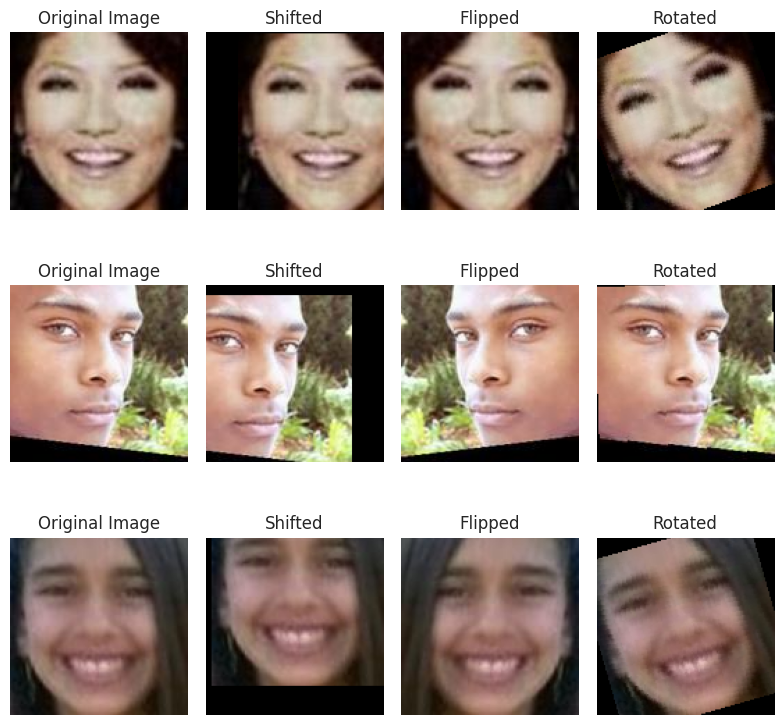

In [7]:
# create a 3x3 grid of images
fig, axis = plt.subplots(3, 4, figsize=(8, 8))
axis = axis.flatten()

for i, img in zip(range(0, 12, 4), X[:5]):
    img = img.copy()/255
    axis[i].imshow(img)
    axis[i].axis(False)
    axis[i].set_title("Original Image")

    axis[i+1].imshow(shift_image(img[np.newaxis, ...])[0])
    axis[i+1].axis(False)
    axis[i+1].set_title("Shifted")

    axis[i+2].imshow(horizontal_flip(img[np.newaxis, ...])[0])
    axis[i+2].axis(False)
    axis[i+2].set_title("Flipped")

    img = img.copy()*255
    axis[i+3].imshow(rotate_image(img[np.newaxis, ...])[0])
    axis[i+3].axis(False)
    axis[i+3].set_title("Rotated")

plt.tight_layout()
plt.show()

# Creating a Model from Scratch

## Building the Model

In [8]:
os.chdir("..")

# image shape
INPUT_SHAPE = (128, 128, 3)

# for gender classification
OUTPUT_SHAPE = 2

# define the input layer
input_layer = Input(INPUT_SHAPE)

# define the cnn layers
cnn_layers = [
    Conv2D(64, (3, 3), input_shape=INPUT_SHAPE, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
]

flat = input_layer
for layer in cnn_layers:
    flat = layer(flat)

# define the dense layers for age prediction
dense1 = Dense(128, activation='relu')(flat)
dropout1 = Dropout(0.3)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.3)(dense2)
age_output = Dense(1, activation='relu', name="age")(dropout2)

# define the dense layers for gender classification
dense3 = Dense(64, activation='relu')(flat)
dropout3 = Dropout(0.3)(dense3)
dense4 = Dense(64, activation='relu')(dropout3)
dropout4 = Dropout(0.3)(dense4)
gender_output = Dense(1, activation='sigmoid', name="gender")(dropout4)

# create the model
model = Model(input_layer, [gender_output, age_output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 32)           18464     ['max_pooling2d[0][0]']   

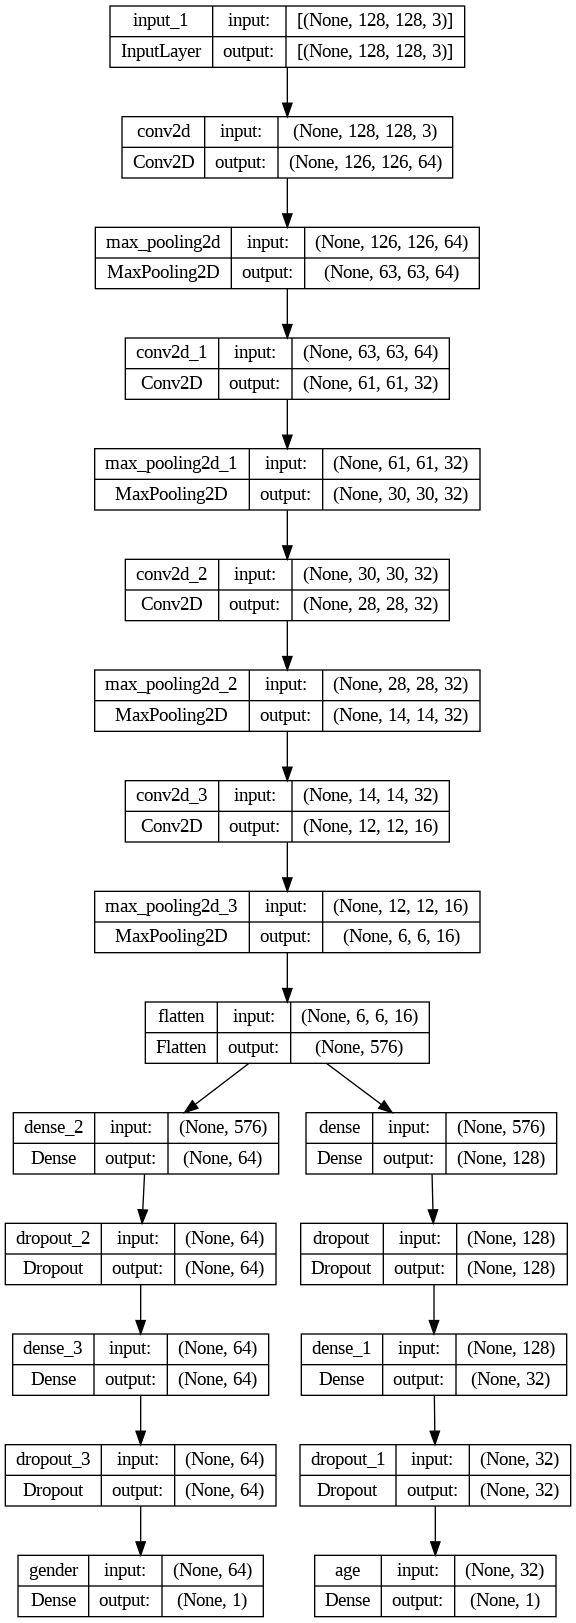

In [9]:
# plot the model architecture
plot_model(model, show_shapes=True)

## Compiling & Training the Model

In [ ]:
# set a decaying learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

# choose the Adam optimizer
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# compiling the model
model.compile(
    optimizer=optimizer,
    loss=['mse', 'binary_crossentropy'],
    metrics=['mae', 'accuracy']
)

# add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=1,
    mode='min',
    restore_best_weights=True,
)

batch_size = 64
epochs = 100

# training the model and saving the history
history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_test, Y_test),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)

# saving the model
model_folder = "Trained Models" + os.sep
os.makedirs(model_folder, exist_ok=True)
model.save(model_folder+"from_scratch_model.keras")

Epoch 1/100
125/125 [==============================] - 303s 2s/step - loss: 482.7673 - gender_loss: 721.7789 - age_loss: -239.0116 - gender_mae: 16.3920 - gender_accuracy: 0.2693 - age_mae: 56264753152.0000 - age_accuracy: 0.2696 - val_loss: 469.4404 - val_gender_loss: 709.6540 - val_age_loss: -240.2136 - val_gender_mae: 16.2525 - val_gender_accuracy: 0.2758 - val_age_mae: 71016996864.0000 - val_age_accuracy: 0.2758
Epoch 2/100
 56/125 [============>.................] - ETA: 2:33 - loss: 484.6879 - gender_loss: 727.7289 - age_loss: -243.0411 - gender_mae: 16.4396 - gender_accuracy: 0.2715 - age_mae: 70242451456.0000 - age_accuracy: 0.2715

## Plotting the Training History

In [ ]:
# loss of the gender classification over the training and validation set
plt.figure(figsize=(12, 4))
plt.plot(history.history['gender_loss'], label="loss on training set")
plt.plot(history.history['val_gender_loss'], label="loss on validation set")
plt.ylabel("Loss")
plt.title("Loss of the gender classification")
plt.legend(loc="lower right")
plt.show()

# the accuracy of the gender classification over the training and validation set
plt.figure(figsize=(12, 4))
plt.plot(history.history['gender_accuracy'], label="accuracy on training set")
plt.plot(history.history['val_gender_accuracy'], label="accuracy on validation set")
plt.ylabel("Accuracy")
plt.title("Accuracy of the gender classification")
plt.legend(loc="lower right")
plt.show()

# the loss of the age estimation over the training and validation set
plt.figure(figsize=(12, 4))
plt.plot(history.history['age_loss'], label="loss on training set")
plt.plot(history.history['val_age_loss'], label="loss on validation set")
plt.ylabel("Loss")
plt.title("Loss of the age estimation")
plt.legend(loc="lower right")
plt.show()

# the MAE of the age estimation over the training and validation set
plt.figure(figsize=(12, 4))
plt.plot(history.history['age_mae'], label="MAE on training set")
plt.plot(history.history['val_age_mae'], label="MAE on validation set")
plt.ylabel("MAE")
plt.title("MAE of the age estimation")
plt.legend(loc="lower right")
plt.show()

# Fine-tuning a Pre-Trained Model

## Building The Moddel

In [ ]:
# define the input layer
model2_input_layer = Input(INPUT_SHAPE)

# retrieve the base model
base_model = MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)(model2_input_layer)

base_model.trainable = False

global_average_layer = GlobalAveragePooling2D()(base_model)

dense1 = Dense(16, activation='relu')(global_average_layer)
dropout1 = Dropout(0.3)(dense1)
age_output = Dense(1, activation='relu', name="age")(dropout1)

dense2 = Dense(16, activation='relu')(global_average_layer)
dropout2 = Dropout(0.3)(dense2)
gender_output = Dense(1, activation='sigmoid', name="gender")(dropout2)

model2 = Model(model2_input_layer, [gender_output, age_output])
model2.summary()

In [ ]:
# plotting the model architecture
plot_model(model2, show_shapes=True)

## Compiling & Training the Model

In [ ]:
# set a decaying learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

batch_size = 64
epochs = 100
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# compiling the model
model2.compile(
    optimizer=optimizer,
    loss=['mse', 'binary_crossentropy'],
    metrics=['mae', 'accuracy']
)

# add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=1,
    mode='min',
    restore_best_weights=True,
)

# saving the history of the training
history = model2.fit(
    X_train,
    Y_train,
    validation_data=(X_test, Y_test),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)

# saving the model
model_folder = "Trained Models" + os.sep
os.makedirs(model_folder, exists_ok=True)
model2.save(model_folder+"fine_tuned_model.keras")

## Plotting the Training History

In [ ]:
# loss of the gender classification over the training and validation set
plt.figure(figsize=(12, 4))
plt.plot(history.history['gender_loss'], label="loss on training set")
plt.plot(history.history['val_gender_loss'], label="loss on validation set")
plt.ylabel("Loss")
plt.title("Loss of the gender classification")
plt.legend(loc="lower right")
plt.show()

# the accuracy of the gender classification over the training and validation set
plt.figure(figsize=(12, 4))
plt.plot(history.history['gender_accuracy'], label="accuracy on training set")
plt.plot(history.history['val_gender_accuracy'], label="accuracy on validation set")
plt.ylabel("Accuracy")
plt.title("Accuracy of the gender classification")
plt.legend(loc="lower right")
plt.show()

# the loss of the age estimation over the training and validation set
plt.figure(figsize=(12, 4))
plt.plot(history.history['age_loss'], label="loss on training set")
plt.plot(history.history['val_age_loss'], label="loss on validation set")
plt.ylabel("Loss")
plt.title("Loss of the age estimation")
plt.legend(loc="lower right")
plt.show()

# the MAE of the age estimation over the training and validation set
plt.figure(figsize=(12, 4))
plt.plot(history.history['age_mae'], label="MAE on training set")
plt.plot(history.history['val_age_mae'], label="MAE on validation set")
plt.ylabel("MAE")
plt.title("MAE of the age estimation")
plt.legend(loc="lower right")
plt.show()

# Evaluation